In [42]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import tensorflow.keras as keras
import json
import seaborn as sns
import scipy.stats

In [22]:
plt.rcParams["font.family"] = "Liberation Serif"
plt.rcParams["font.weight"] = "bold"    

In [40]:
def compute_stars(pvalue, alpha, return_level=False):
    """ compute the stars to visualize a p-value """
    PVALUE_STARS = [
        1.,
        1/5.,
        1/50.,
        1/500.
    ]

    for i in range(len(PVALUE_STARS)-1, -1, -1):
        level = PVALUE_STARS[i] * alpha
        if pvalue < level:
            if return_level:
                return i+1, level 
            else:
                return i+1

    return 0

# sGO Terms vs SMF

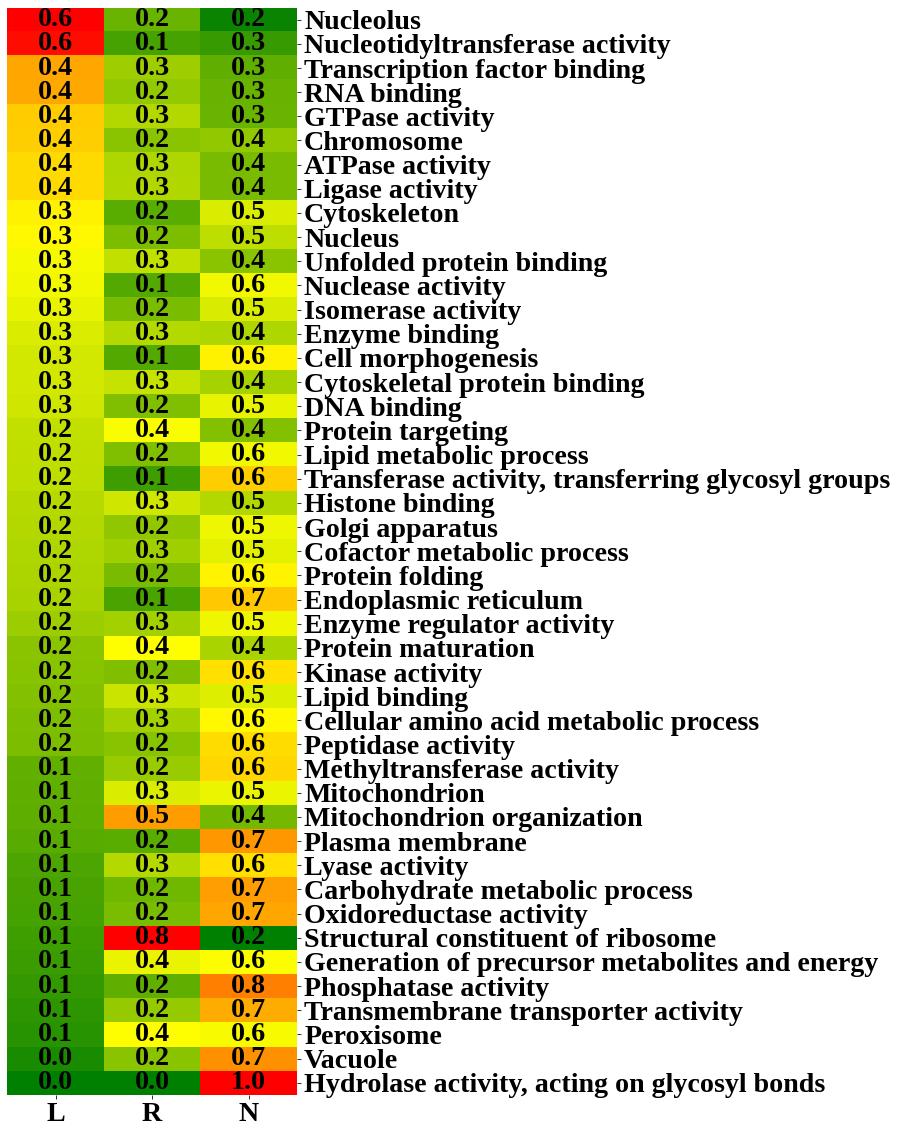

In [23]:
def make_label(s):
    return s[0].upper() + s[1:]

def sgo_terms_vs_smf(task_path):
    
    plot_cfg = {
        "tick_label_size" : 28,
        "xlabel_size" : 60,
        "ylabel_size" : 60,
        "border_size" : 6,
        "bar_border_size" : 2.5,
        "bar_label_size" : 48,
        "stars_label_size" : 48,
        "annot_size" : 24
    }
    
    with open('../generated-data/go_ids_to_names.json', 'r') as f:
        id_to_name = json.load(f)
    
    df = pd.read_feather(task_path)
    
    sdf = df[df.columns[df.columns.str.startswith('sgo-')]]
    
    smf_bin = df['bin']
    
    smf_bin_cat = keras.utils.to_categorical(smf_bin)
    
    sgo_counts = np.dot(np.array(sdf).T, smf_bin_cat)
    sgo_counts = sgo_counts / np.sum(sgo_counts, axis=1, keepdims=True)
    
    cols = [id_to_name[c.replace('sgo-','')] for c in sdf.columns]
    sgo_counts_df = pd.DataFrame(data=sgo_counts, columns=['L', 'R', 'N'], index=cols)
    
    sgo_counts_df.sort_values('L', inplace=True, ascending=False)
    
    vals = np.array(sgo_counts_df[['L', 'R', 'N']])
    orig_vals = vals.copy()

    min_vals = np.min(vals, axis=0, keepdims=True)
    max_vals = np.max(vals, axis=0, keepdims=True)
    vals = (vals - min_vals) / (max_vals - min_vals)

    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["green","yellow","red"])

    f, ax = plt.subplots(1, 1, figsize=(10, 20))
    ax.yaxis.tick_right()
    ax.imshow(vals, aspect=0.25, cmap=cmap)
    plt.setp(ax.spines.values(), linewidth=0, color='black')
    ax.set_yticks(np.arange(sgo_counts_df.shape[0]))
    ax.set_yticklabels([make_label(l) for l in sgo_counts_df.index], fontsize=plot_cfg['tick_label_size'])
    ax.set_xticks([0,1,2])
    ax.set_xticklabels(['L', 'R', 'N'], fontsize=plot_cfg['tick_label_size'])

    for i in range(vals.shape[0]):
        for j in range(vals.shape[1]):
            ax.text(j, i, '%0.1f' % orig_vals[i,j], 
                    color='black', ha="center", va="center", weight='bold', 
                    fontsize=plot_cfg['tick_label_size'])

sgo_terms_vs_smf("../generated-data/dataset_yeast_smf.feather")

# Violin Plot: LID vs SMF

Comparisons: 3, adjusted alpha: 0.016667
L (4.67) vs. R (2.64): 0.000000 [174.830303] (lens 839 vs 994)
L (4.67) vs. N (1.50): 0.000000 [823.436676] (lens 839 vs 2487)
R (2.64) vs. N (1.50): 0.000000 [316.106649] (lens 994 vs 2487)


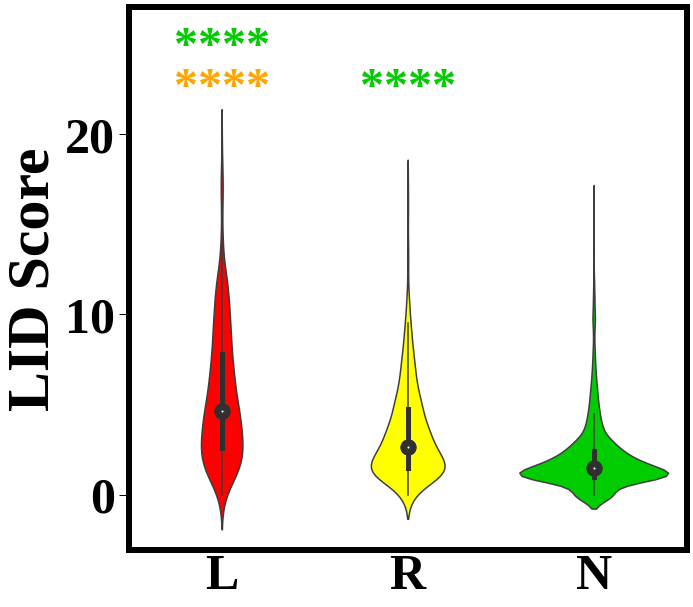

In [44]:
def violin_plot(task_path, feature, ylabel, bins, ylim=None, alpha=0.05):
    plot_cfg = {
        "tick_label_size" : 50,
        "xlabel_size" : 60,
        "ylabel_size" : 60,
        "border_size" : 6,
        "bar_border_size" : 2.5,
        "bar_label_size" : 48,
        "stars_label_size" : 48,
        "annot_size" : 82,
        "iqr_color" : "#303030",

    }
    df = pd.read_feather(task_path)
    df['labeled_bin'] = bins[df['bin'].astype(int)]
    
    colors = ['#FF0000', '#FFFF00', '#00CC00']
    star_colors = ['#FF0000', 'orange', '#00CC00']
    f, ax = plt.subplots(1, 1, figsize=(10, 10))
    ax = sns.violinplot(x="labeled_bin", y=feature, ax=ax, order=bins, data=df, 
        palette=colors, saturation=1)
    ax.yaxis.set_tick_params(labelsize=plot_cfg['tick_label_size'])
    ax.xaxis.set_tick_params(labelsize=plot_cfg['tick_label_size'])
    ax.set_ylabel(ylabel, fontsize=plot_cfg['ylabel_size'], weight='bold')
    ax.set_xlabel('')
    ax.set_xlim([-0.5, 2.5])
    ax.yaxis.set_tick_params(length=10, width=1, which='both')
    ax.xaxis.set_tick_params(length=0)

    max_val = np.max(df[feature])
    if ylim:
        ax.set_ylim(ylim)
    else:
        min_val, max_val = ax.get_ylim()
        ax.set_ylim([min_val, max_val*1.2])
    ax.grid(False)
    plt.setp(ax.spines.values(),linewidth=plot_cfg["border_size"], color='black')
    
    # compute adjusted p-values for pairwise comparisons
    num_comparisons = len(bins) * (len(bins)-1) / 2
    adjusted_alpha = alpha / num_comparisons
    print("Comparisons: %d, adjusted alpha: %f" % (num_comparisons, adjusted_alpha))
    
    
    # increase thickness of median and IQR
    for i in range(len(bins)):
        a = df[df['labeled_bin'] == bins[i]][feature]
        a_med = np.median(a)
        ax.plot([i, i], [a_med, a_med], 'o', color=plot_cfg['iqr_color'], markersize=15)
        iqr_lower = np.percentile(a, 25)
        iqr_upper = np.percentile(a, 75)
        ax.plot([i, i], [iqr_lower, iqr_upper], linewidth=5, color=plot_cfg['iqr_color'])
        
        yoffset = max_val
        
        for j in range(i+1, len(bins)):
            b = df[df['labeled_bin'] == bins[j]][feature]
            statistic, pvalue = scipy.stats.kruskal(a, b)
            print("%s (%0.2f) vs. %s (%0.2f): %0.6f [%0.6f] (lens %d vs %d)" % (bins[i], 
                np.median(a), bins[j], np.median(b), pvalue, statistic, a.shape[0], b.shape[0]))
            
            if pvalue < adjusted_alpha:
                stars = '*' * compute_stars(pvalue, adjusted_alpha)
                target_color = star_colors[j]
                ax.text(i, yoffset, stars, 
                    color=target_color, ha="center", va="center", weight='bold', 
                    fontsize=plot_cfg['stars_label_size'])
                yoffset += 0.1 * max_val
violin_plot("../generated-data/dataset_yeast_smf.feather", "topology-lid", "LID Score", np.array(['L','R','N']))

# Violin Plot: Percent Identity Score vs SMF

Comparisons: 3, adjusted alpha: 0.016667
L (0.00) vs. R (22.36): 0.000019 [18.241974] (lens 839 vs 994)
L (0.00) vs. N (29.44): 0.000000 [143.794084] (lens 839 vs 2487)
R (22.36) vs. N (29.44): 0.000000 [36.996009] (lens 994 vs 2487)


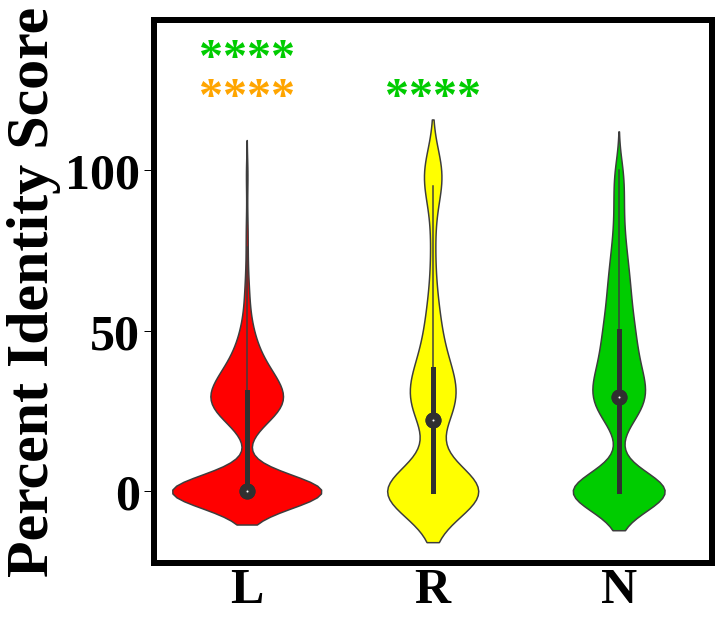

In [45]:
violin_plot("../generated-data/dataset_yeast_smf.feather", "redundancy-pident", "Percent Identity Score", np.array(['L','R','N']))